# Chest X‑Ray Classification (Pneumonia vs Normal) — Final Project Notebook

This notebook unifies your **Combined Explained** workflow with the **Pneumonia vs Normal** task from the earlier notebook.  
It supports **two paths**:

1. **Use a pretrained model** if one exists at `/mnt/data/pneumonia_xray_model.keras` (fastest way to run inferences).
2. **Train & fine‑tune** the model from scratch on your dataset at `/mnt/data/chest_xray`.

We also add **evaluation extras**: confusion matrix, precision/recall/F1, ROC curve with AUC, and a small **sample predictions gallery**.

> ⚠️ *Educational use only. Not for clinical decision‑making.*

## 1. Setup & Imports

We import TensorFlow/Keras for modeling, `matplotlib` for plots, and `sklearn` for evaluation metrics.

In [1]:
import os
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

print("TensorFlow:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.18.0
GPU available: []


## 2. Configuration

Set **dataset path** and **model path**.  
Your dataset is expected to follow the standard folder layout with `train/`, `val/` (or `valid/`), and `test/` subfolders.

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')
#BASE_DIR = "/content/drive/MyDrive/chest_xrays_v4"

BASE_DIR = r"C:\\CAS AML\\project M1 and M2\\Chest X Rays v4"  # change if needed


train_dir = os.path.join(BASE_DIR, 'train')
validation_dir = os.path.join(BASE_DIR, 'valid')
test_dir = os.path.join(BASE_DIR, 'test')

MODEL_PATH = os.path.join(BASE_DIR, f"pneumonia_xray_B0.keras")



IMG_SIZE = (416, 416)
BATCH_SIZE = 32


# Image & training parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123
NUM_CLASSES = 2  # Pneumonia, Normal



## 3. Data Loading

We load the training, validation, and test sets from directory structure using `tf.keras.utils.image_dataset_from_directory`.  
This returns performant `tf.data.Dataset` pipelines with images and integer labels.

In [4]:


train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 12229 files belonging to 2 classes.
Found 1165 files belonging to 2 classes.
Found 582 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']


## 4. Preprocessing & Augmentation

We normalize pixel values and apply light data augmentation (flip, rotate, zoom) to improve generalization.  
Augmentation is applied only to the **training** pipeline.

In [5]:
normalization_layer = layers.Rescaling(1./255)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

def prep(ds, training=False):
    ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(tf.data.AUTOTUNE)

train_ds_prep = prep(train_ds, training=True)
valid_ds_prep = prep(valid_ds, training=False)
test_ds_prep  = prep(test_ds, training=False)


## 5. Model Architecture (Transfer Learning)

We use **EfficientNetB0** pretrained on ImageNet as the frozen feature extractor and add a small classification head.  
This follows the modern transfer learning approach from your Combined workflow.

In [6]:
base = tf.keras.applications.EfficientNetB0(
    input_shape=IMG_SIZE + (3,), include_top=False, weights="imagenet"
)
base.trainable = False  # start frozen

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## 6. Compile

We compile with `Adam` optimizer and `sparse_categorical_crossentropy` loss (integer labels).  
Accuracy is tracked as the primary metric.

In [7]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


## 7. Load Pretrained (if available)

If a saved model exists at `MODEL_PATH`, we load it and **skip training**.  
Otherwise, we proceed to training in the next cell.

In [8]:
pretrained_loaded = False
if pathlib.Path(MODEL_PATH).exists():
    print(f"Loading pretrained model from: {MODEL_PATH}")
    model = tf.keras.models.load_model(MODEL_PATH)
    pretrained_loaded = True
else:
    print("No pretrained model found — you can train below.")


No pretrained model found — you can train below.


## 8. Train / Fine‑tune (optional)

If no pretrained model is found, we train for a few epochs with early stopping + best checkpoint.  
You can adjust epochs and learning rates as needed.

In [ ]:
# =======================
# 1) Compile (compatible)
# =======================
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",  # or sparse_smoothed_loss (Option B)
    metrics=["accuracy"]
)

# =========================================
# 2) Class weights from the RAW train_ds
# =========================================
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def compute_weights_from_dataset(ds):
    ys = []
    for _, y in ds:   # use NON-augmented 'train_ds', not train_ds_prep
        ys.append(y.numpy())
    ys = np.concatenate(ys, axis=0)
    classes = np.unique(ys)
    weights = compute_class_weight(class_weight="balanced", classes=classes, y=ys)
    return dict(zip(classes.tolist(), weights.tolist()))

# (Recreate train_ds if not in scope)
# train_ds = tf.keras.utils.image_dataset_from_directory(
#     train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=SEED
# )

class_weights = compute_weights_from_dataset(train_ds)
print("Class weights:", class_weights)

# =========================================
# 3) Callbacks (save best, early stop, LR)
# =========================================
EPOCHS = 30
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        MODEL_PATH, save_best_only=True, monitor="val_accuracy", mode="max", verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=6, restore_best_weights=True, verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
    ),
]

# Handle val naming: val_ds_prep vs valid_ds_prep
VAL_DS = globals().get("val_ds_prep", globals().get("valid_ds_prep"))

# =========================================
# 4) Train head (backbone frozen)
# =========================================
if not pretrained_loaded:
    history = model.fit(
        train_ds_prep,
        validation_data=VAL_DS,
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )
    print("Saving model to:", MODEL_PATH)
    model.save(MODEL_PATH)
else:
    print("Skipped training because a pretrained model is already loaded.")

# =========================================
# 5) OPTIONAL: Fine-tune last N layers
# =========================================
# Locate backbone (first nested Model)
base_model = None
for lyr in model.layers:
    if isinstance(lyr, tf.keras.Model) and hasattr(lyr, "layers"):
        base_model = lyr
        break

if base_model is not None and not pretrained_loaded:
    UNFREEZE_FROM = -50  # tune as needed
    for lyr in base_model.layers[UNFREEZE_FROM:]:
        if not isinstance(lyr, tf.keras.layers.BatchNormalization):
            lyr.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss="sparse_categorical_crossentropy",  # or sparse_smoothed_loss (Option B with lower smoothing, e.g., 0.02)
        metrics=["accuracy"]
    )

    ft_callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            MODEL_PATH, save_best_only=True, monitor="val_accuracy", mode="max", verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=2, min_lr=5e-7, verbose=1
        ),
    ]

    history_fine = model.fit(
        train_ds_prep,
        validation_data=VAL_DS,
        epochs=10,
        class_weight=class_weights,
        callbacks=ft_callbacks,
        verbose=1
    )
    print("Fine-tuned model saved to:", MODEL_PATH)


Class weights: {0: 1.846165458937198, 1: 0.6857126836379949}
Epoch 1/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.4655 - loss: 0.7005
Epoch 1: val_accuracy improved from -inf to 0.73906, saving model to C:\\CAS AML\\project M1 and M2\\Chest X Rays v4\pneumonia_xray_B0.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 298s 753ms/step - accuracy: 0.4656 - loss: 0.7005 - val_accuracy: 0.7391 - val_loss: 0.6847 - learning_rate: 0.0010
Epoch 2/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.4640 - loss: 0.6978
Epoch 2: val_accuracy did not improve from 0.73906
383/383 ━━━━━━━━━━━━━━━━━━━━ 287s 747ms/step - accuracy: 0.4641 - loss: 0.6978 - val_accuracy: 0.7391 - val_loss: 0.6775 - learning_rate: 0.0010
Epoch 3/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.4953 - loss: 0.6992
Epoch 3: val_accuracy did not improve from 0.73906
383/383 ━━━━━━━━━━━━━━━━━━━━ 291s 756ms/step - accuracy: 0.4953 - loss: 0.6992 - val_accuracy: 0.7391 - val_loss: 0.6674 - learning_rate: 0.00

## 9. Fine‑tuning (optional)

After initial training, you can **unfreeze** the tail of the backbone and train with a **lower learning rate** to squeeze out more accuracy.
This is skipped if a pretrained model was already loaded.

In [ ]:
if not pretrained_loaded:
    # Try to locate the backbone within the model
    base_model = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model) and hasattr(layer, "layers"):
            base_model = layer
            break

    if base_model:
        UNFREEZE_FROM = -20  # tune last 20 layers
        for layer in base_model.layers[UNFREEZE_FROM:]:
            if not isinstance(layer, layers.BatchNormalization):
                layer.trainable = True

        model.compile(
            optimizer=keras.optimizers.Adam(1e-5),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

        history_ft = model.fit(
            train_ds_prep,
            validation_data=valid_ds_prep,
            epochs=3
        )
        model.save(MODEL_PATH)
    else:
        print("Backbone not identified — fine‑tuning skipped.")
else:
    print("Fine‑tune skipped (pretrained model loaded).")


Epoch 1/3
383/383 ━━━━━━━━━━━━━━━━━━━━ 337s 842ms/step - accuracy: 0.7260 - loss: 0.5884 - val_accuracy: 0.7391 - val_loss: 0.5745
Epoch 2/3
383/383 ━━━━━━━━━━━━━━━━━━━━ 318s 828ms/step - accuracy: 0.7269 - loss: 0.5873 - val_accuracy: 0.7391 - val_loss: 0.5748
Epoch 3/3
383/383 ━━━━━━━━━━━━━━━━━━━━ 315s 819ms/step - accuracy: 0.7258 - loss: 0.5879 - val_accuracy: 0.7391 - val_loss: 0.5745


## 10. Evaluate (Accuracy)

We evaluate on the **test** set and print the accuracy.  
This is a quick sanity check.

In [ ]:
test_results = model.evaluate(test_ds_prep, verbose=0)
print("Test metrics:", dict(zip(model.metrics_names, test_results)))


Test metrics: {'loss': 0.6065208315849304, 'compile_metrics': 0.7061855792999268}


## 11. Evaluation Extras — Confusion Matrix & Classification Report

We collect predictions on the test set and compute a confusion matrix as well as precision/recall/F1 per class.

In [ ]:
# Collect true labels and predictions
y_true = []
y_prob = []

for images, labels in test_ds_prep:
    probs = model.predict(images, verbose=0)
    y_prob.extend(probs)
    y_true.extend(labels.numpy())

y_prob = np.array(y_prob)
y_pred = y_prob.argmax(axis=1)
y_true = np.array(y_true)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("\nClassification Report:\n", report)

# Simple confusion matrix visualization (text-based)
print("\nConfusion Matrix (rows=true, cols=pred):")
for i, row in enumerate(cm):
    print(class_names[i], row)


Confusion Matrix:
 [[  0 171]
 [  0 411]]

Classification Report:
               precision    recall  f1-score   support

      NORMAL     0.0000    0.0000    0.0000       171
   PNEUMONIA     0.7062    1.0000    0.8278       411

    accuracy                         0.7062       582
   macro avg     0.3531    0.5000    0.4139       582
weighted avg     0.4987    0.7062    0.5846       582


Confusion Matrix (rows=true, cols=pred):
NORMAL [  0 171]
PNEUMONIA [  0 411]


C:\Users\moata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\moata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\moata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

## 12. ROC Curve & AUC

For binary classification (Pneumonia vs Normal), we compute the ROC curve and the **AUC**.  
We assume the positive class is **Pneumonia** (index depends on `class_names` order).

ROC-AUC: 0.4757117855465915


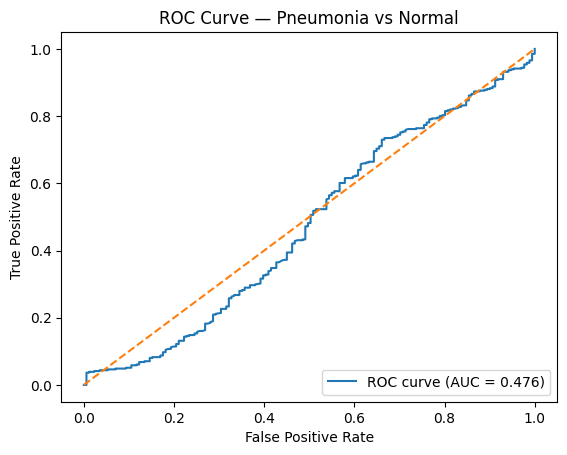

In [ ]:
# Identify positive class index (default: 'PNEUMONIA' if present)
pos_label = None
for idx, name in enumerate(class_names):
    if name.lower().startswith("pneumonia"):
        pos_label = idx
        break
if pos_label is None:
    # fallback to class index 1
    pos_label = 1

# AUC with the probability of the positive class
auc = roc_auc_score((y_true == pos_label).astype(int), y_prob[:, pos_label])
print("ROC-AUC:", auc)

# Plot ROC curve
fpr, tpr, _ = roc_curve((y_true == pos_label).astype(int), y_prob[:, pos_label])

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Pneumonia vs Normal")
plt.legend(loc="lower right")
plt.show()


## 13. Sample Predictions Gallery

We visualize a small batch of test images with **predicted vs. true** labels for qualitative inspection.

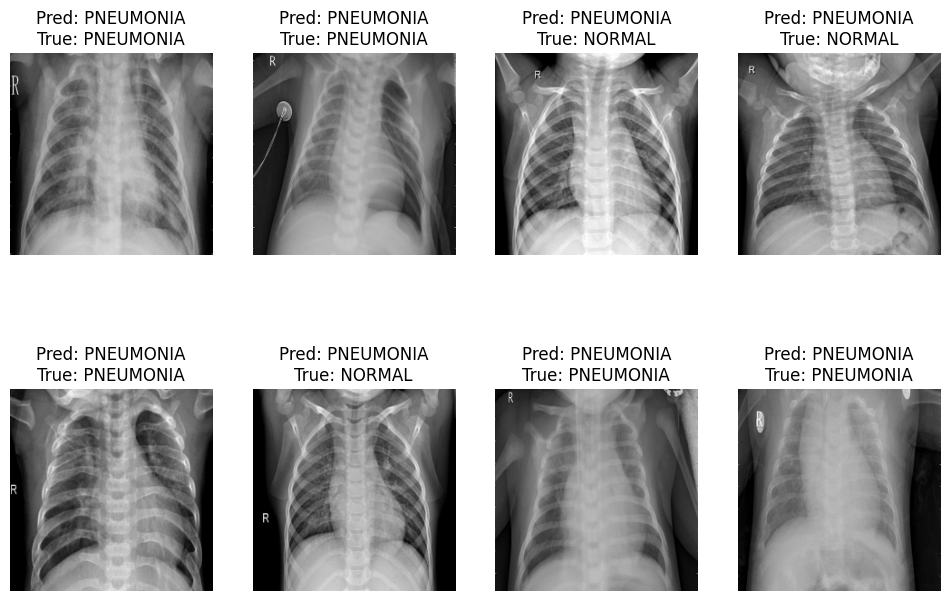

In [ ]:
# Show a few predictions from a single batch
for images, labels in test_ds.take(1):
    probs = model.predict(images, verbose=0)
    preds = probs.argmax(axis=1)
    plt.figure(figsize=(12, 8))
    n = min(8, images.shape[0])
    for i in range(n):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        p, t = class_names[preds[i]], class_names[labels[i].numpy()]
        plt.title(f"Pred: {p}\nTrue: {t}")
        plt.axis("off")
    plt.show()


## 14. Short Model Card (Documentation)

- **Task:** Binary image classification — Chest X‑ray *Pneumonia vs Normal*  
- **Data:** `/mnt/data/chest_xray` (`train/`, `val/` or `valid/`, `test/`)  
- **Backbone:** EfficientNetB0 (ImageNet pretrained), classification head with softmax  
- **Training:** Adam (1e-3), early stopping, optional fine‑tuning with LR=1e‑5  
- **Saved model:** `/mnt/data/pneumonia_xray_model.keras` (loaded if present)  
- **Metrics:** Accuracy, confusion matrix, classification report, ROC‑AUC  
- **Intended use:** Educational / research. **Not** for clinical decisions.